# IMBD Movie Reviews

In this tutorial we will work with the IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

The IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary. This enables us to focus on model building, training, and evaluation.

## Loading the Data Set

The following code will load the dataset (when you run it the first time, about 80 MB of data will be downloaded to your machine).

The argument `num_words=10000` means you’ll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size. If we didn’t set this limit, we’d be working with 88,585 unique words in the training data, which is unnecessarily large. Many of these words only occur in a single sample, and thus can’t be meaningfully used for classification.

In [ ]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)

2023-11-07 13:46:55.134895: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 13:46:55.170619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 13:46:55.170648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 13:46:55.170677: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 13:46:55.176988: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 13:46:55.177807: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

The variables `train_data` and `test_data` are lists of reviews; each review is a list of
word indices (encoding a sequence of words).

In [ ]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


`train_labels` and `test_labels` are `lists` of 0s and 1s, where `0` stands for negative and `1` stands for positive.

In [ ]:
train_labels[0]

1

Because we’re restricting ourselves to the top 10,000 most frequent words, no word index will exceed 10,000.

In [ ]:
max([max(sequence) for sequence in train_data])

9999

## Decoding Reviews

For purposes of illustration, the following code decodes one of the reviews back to text.

In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()]
)
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]
)

In [ ]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Preparing the Data

You can’t directly feed lists of integers into a neural network. They all have different lengths, but a neural network expects to process contiguous batches of data. You have to turn your lists into tensors.  In particular we will use *multi-hot encoding*.

This would mean, for instance, turning the sequence [8, 5] into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then you could use a `Dense` layer, capable of handling floating-point vector data, as the first layer in your model.

The following code performs the multi-hot encoding.  Notice that we are *flattening* our text data so that we are losing all sense of ordering of the words.

In [ ]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Here’s what the samples look like now:

In [ ]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Let's also vectorize the labels.

In [ ]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

## Building the Model

The input data is vectors, and the labels are scalars (1s and 0s): this is one of the simplest problem setups you’ll ever encounter. A type of model that performs well on such a problem is a plain stack of densely connected (`Dense`) layers with `relu` activations.

There are two key architecture decisions to be made about such a stack of `Dense` layers:

- How many layers to use
- How many units to choose for each layer

We will use two hidden layers with 16 units each and a `relu` activation function.  Since we are predicting a single outcome (positive or negative) our output layer will have a single unit and we will use a `sigmoid` activation because this is a binary classification problem.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

Finally, you need to choose a loss function and an optimizer. Because you’re facing a binary classification problem and the output of your model is a probability (you end your model with a single-unit layer with a sigmoid activation), it’s best to use the `binary_crossentropy` loss. It isn’t the only viable choice: for instance, you could use `mean_squared_error`. But crossentropy is usually the best choice when you’re dealing with models that output probabilities.

As for the choice of the optimizer, we’ll go with `rmsprop`, which is a usually a good default choice for virtually any problem.

In [ ]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

## Creating a Validation Set

A deep learning model should never be evaluated on its training data — it’s standard practice to use a validation set to monitor the accuracy of the model during training. Here, we’ll create a validation set by setting apart 10,000 samples from the original training data.

In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

## Training the Model

We will now train the model for 20 epochs (20 iterations over all samples in the training data) in mini-batches of 512 samples. At the same time, we will monitor loss and accuracy on the 10,000 samples that we set apart. We do so by passing the validation data as the `validation_data` argument.

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20


2023-11-07 13:52:47.420717: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 600000000 exceeds 10% of free system memory.


27/30 [==========================>...] - ETA: 0s - loss: 0.5326 - accuracy: 0.7713

2023-11-07 13:52:48.719414: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 400000000 exceeds 10% of free system memory.


30/30 [==============================] - 1s 32ms/step - loss: 0.5202 - accuracy: 0.7799 - val_loss: 0.3975 - val_accuracy: 0.8579
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.3163 - accuracy: 0.8985 - val_loss: 0.3150 - val_accuracy: 0.8773
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2351 - accuracy: 0.9231 - val_loss: 0.2828 - val_accuracy: 0.8882
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1887 - accuracy: 0.9397 - val_loss: 0.2874 - val_accuracy: 0.8842
Epoch 5/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1590 - accuracy: 0.9471 - val_loss: 0.3151 - val_accuracy: 0.8760
Epoch 6/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1356 - accuracy: 0.9569 - val_loss: 0.2940 - val_accuracy: 0.8816
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1145 - accuracy: 0.9665 - val_loss: 0.3222 - val_accuracy: 0.8733
Epoch 8/20
30/30 [======

The call to `model.fit()` returns a `history` object. This object has a member `history`, which is a dictionary containing data about everything that happened during training. Let’s look at it:

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Plotting the Training and Validation Loss

Let’s use **matplotlib** to plot the training and validation loss side by side as well as the training and
validation accuracy. Note that your own results may vary slightly due to a different random initialization of your model.

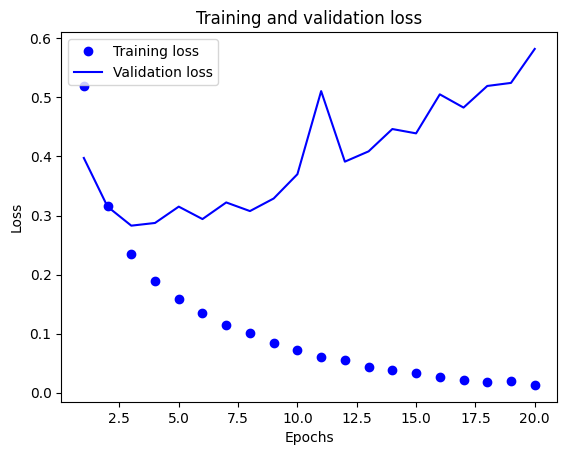

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

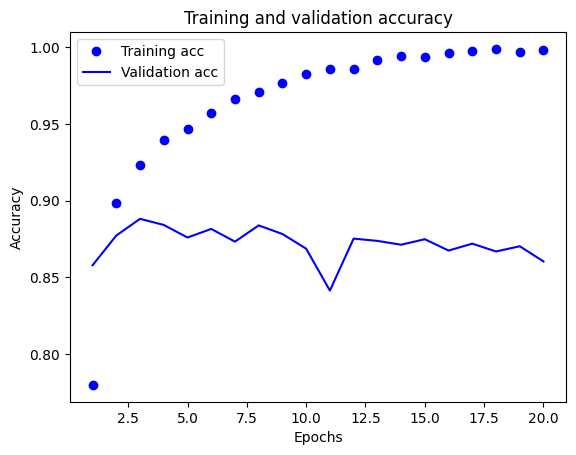

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy
increases with every epoch. That’s what you would expect when running gradient-
descent optimization — the quantity you’re trying to minimize should be less with
every iteration. But that isn’t the case for the validation loss and accuracy: they seem to
peak at the fourth epoch. What you’re seeing is overfitting: after the fourth epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

In this case, to prevent overfitting, you could stop training after four epochs.

## Retraining the Model with Four Epochs

Let’s train a new model from scratch for four epochs and then evaluate it on the test data.

In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4


2023-11-07 13:54:48.663915: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1000000000 exceeds 10% of free system memory.


49/49 [==============================] - 1s 9ms/step - loss: 0.4965 - accuracy: 0.8072
Epoch 2/4
49/49 [==============================] - 0s 8ms/step - loss: 0.2924 - accuracy: 0.8979
Epoch 3/4
49/49 [==============================] - 0s 9ms/step - loss: 0.2256 - accuracy: 0.9191
Epoch 4/4
  1/782 [..............................] - ETA: 1:02 - loss: 0.3020 - accuracy: 0.8438

2023-11-07 13:54:53.967576: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1000000000 exceeds 10% of free system memory.


782/782 [==============================] - 1s 1ms/step - loss: 0.2792 - accuracy: 0.8873


The final results are below.  This fairly naive approach achieves an accuracy of 88%. With state-of-the-art
approaches, you should be able to get close to 95%.

In [ ]:
results

[0.27919963002204895, 0.8872799873352051]

## Generating Predictions on New Data

After having trained a model, you’ll want to use it on new data. You can generate the likelihood of reviews being positive by using the `.predict()` method.

In [ ]:
model.predict(x_test)

2023-11-07 13:55:18.938415: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1000000000 exceeds 10% of free system memory.


782/782 [==============================] - 1s 1ms/step


array([[0.1812639 ],
       [0.9998338 ],
       [0.8731738 ],
       ...,
       [0.08835417],
       [0.0980044 ],
       [0.631039  ]], dtype=float32)

## Further Exploration

The following experiments will help convince you that the architecture choices you’ve
made are all fairly reasonable, although there’s still room for improvement:

- You used two representation layers before the final classification layer. Try using
one or three representation layers, and see how doing so affects validation and
test accuracy.
- Try using layers with more units or fewer units: 32 units, 64 units, and so on.
- Try using the `mse` loss function instead of `binary_crossentropy`.
- Try using the `tanh` activation (an activation that was popular in the early days of
neural networks) instead of `relu`.